<div style="display:fill;
           background-color:#89B9AD88;
           letter-spacing:0.5px;border-bottom: 2px solid black;">
<img src="https://raw.githubusercontent.com/IqmanS/Machine-Learning-Notebooks/main/mohs_hardness/mohs-banner.jpg">
    
<H1 style="padding: 20px; color:black; font-weight:600;font-family: 'Garamond', 'Lucida Sans', sans-serif; text-align: center; font-size: 36px;text-transform: uppercase;">Regression with Mohs Hardness Dataset</H1>
</div>

In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import os
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark") # Theme for plots as Da1. Dataset Overviewrk
sns.set_palette("viridis")
# sns.color_palette("flare")
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
import optuna
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from catboost import Pool, CatBoostRegressor, cv

<div style="background-color: #89B9AD88; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
    Table of Contents
    </h1>
</div>
<br>
<a href="#1" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 22px;"> 1. Dataset Overview </a><br>
<a href="#2" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 22px;"> 2. EDA </a><br>
<a href="#4" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 22px;"> 3. Training Models </a><br>
<a href="#4.1" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 16px;padding-left: 25px;"> 3.1 Baseline RandomForest Model </a><br>
<a href="#4.2" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 16px;padding-left: 25px;"> 3.2 Baseline CatBoost Model </a><br>
<a href="#4.3" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 16px;padding-left: 25px;"> 3.3 Baseline LGBM Model </a><br>
<a href="#4.4" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 16px;padding-left: 25px;"> 3.4 Baseline XGB Model </a><br>
<a href="#4.5" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 16px;padding-left: 25px;"> 3.5 Optuna LGBM Model </a><br>
<a href="#4.6" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 16px;padding-left: 25px;"> 3.6 Optuna XGB Model </a><br>
<a href="#4.7" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 16px;padding-left: 25px;"> 3.7 Voting Regressor </a><br>
<a href="#6" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 22px;"> 4. Plotting Feature Importance </a><br>
<a href="#7" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 22px;"> 5. Creating 'submission.csv' </a><br>
<a href="#8" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 22px;"> 6. Conclusion </a>

<div id="1" style="background-color: #89B9AD88; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
    Dataset Overview
    </h1>
</div>

In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s3e25/train.csv", index_col="id")
test_data = pd.read_csv("/kaggle/input/playground-series-s3e25/test.csv",index_col="id")
sample = pd.read_csv("/kaggle/input/playground-series-s3e25/sample_submission.csv")

In [3]:
train_data.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 1.0 MB


In [5]:
train_data.describe()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


<div id="2" style="background-color: #89B9AD88; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
    Exploratory Data Analysis
    </h1>
</div>

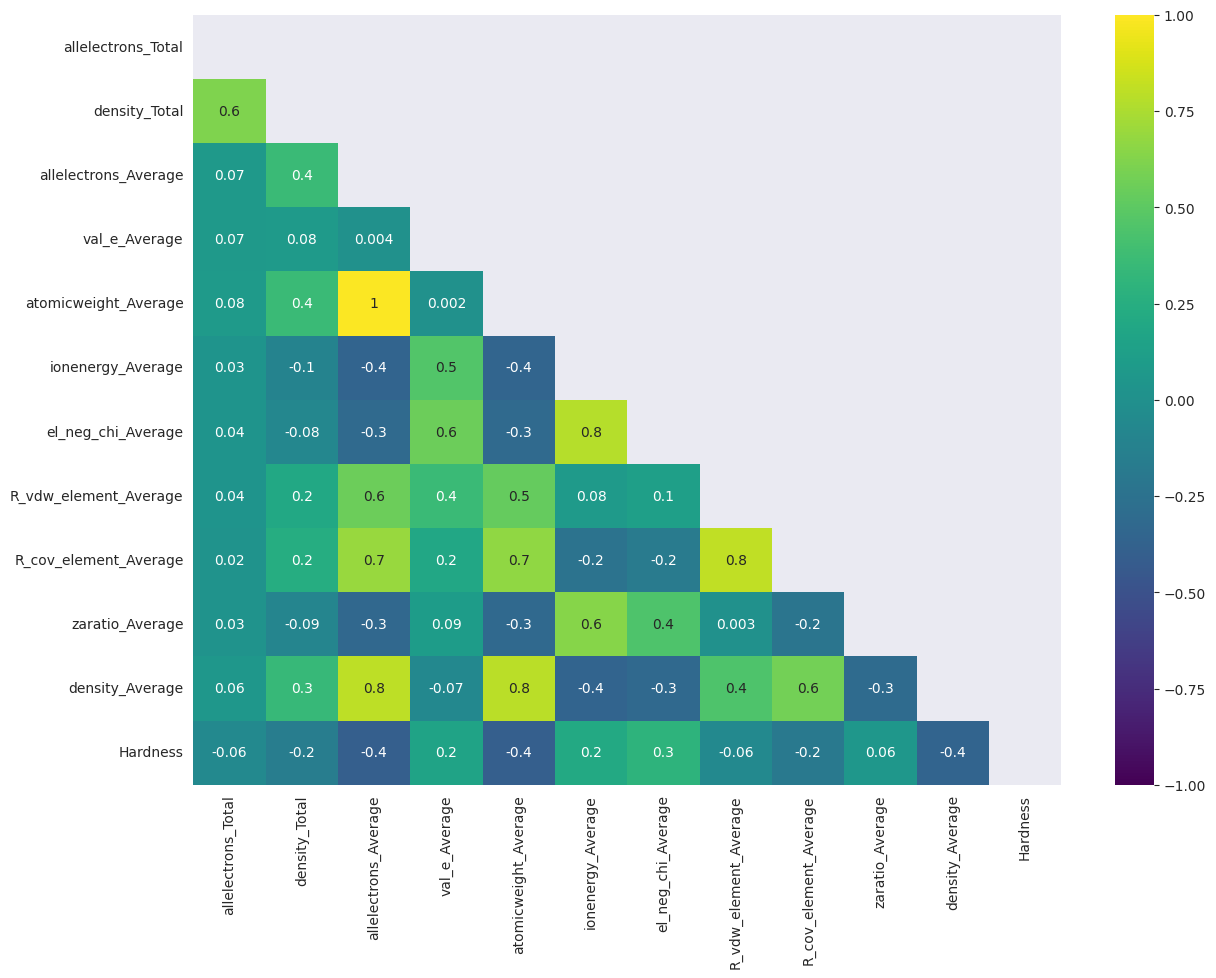

In [6]:
mask = np.triu(np.ones_like(train_data.corr()))
plt.figure(figsize=(14,10))
sns.heatmap(train_data.corr(), cmap="viridis", annot=True, mask=mask,vmin=-1,vmax=1,fmt=".1g");

In [7]:
fig,axes = plt.subplots(12,2,figsize=(15, 40),dpi=300)

for ind,col in enumerate(train_data.columns):
    plt.subplot(12,2,2*ind+1)
    sns.histplot(train_data[col],bins=15,kde=True)
    plt.gca().set_title(col)
    
    plt.subplot(12,2,2*ind+2)
    sns.boxplot(train_data[col],orient="h")
    plt.gca().set_title(col)

fig.tight_layout()
plt.show()

<div id="4" style="background-color: #89B9AD88; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
    Training Models
    </h1>
</div>

In [8]:
seed = np.random.seed(6)

X = train_data.drop(["Hardness"],axis=1)
y = train_data["Hardness"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

<div id="4.1" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: left; color: #263A29; font-weight: normal; font-size: 26px;">
  - Evaluation Metric (Median Abs Error):
    </h1>
</div>
\begin{align}
MedAE (y,\hat{y}) = median(| y_i - \hat {y}_i |,...,| y_n - \hat {y}_n |)
\end{align}
<br>




<div id="4.1" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   3.1 Baseline RandomForest Model
    </h1>
</div>
<hr>

In [9]:
rfmodel = RandomForestRegressor(random_state=seed)
rfmodel.fit(X,y)
print("CV MedAE of Baseline RF is",-1*cross_val_score(rfmodel,X,y,cv=4,scoring="neg_median_absolute_error").mean())

CV MedAE of Baseline RF is 0.6656250000000001


<div id="4.2" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   3.2 Baseline CatBoost Model
    </h1>
</div>
<hr>

In [10]:
catmodel = CatBoostRegressor(random_state=seed,verbose=0)
catmodel.fit(X,y)
print("CV MedAE of Baseline Cat is",-1*cross_val_score(catmodel,X,y,cv=4,scoring="neg_median_absolute_error").mean())

CV MedAE of Baseline Cat is 0.6578649883602484


<div id="4.3" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   3.3 Baseline LGBM Model
    </h1>
</div>
<hr>

In [11]:
lgbmmodel = LGBMRegressor(random_state=seed)
lgbmmodel.fit(X,y)
print("CV MedAE of Baseline LGBM is",-1*cross_val_score(lgbmmodel,X,y,cv=4,scoring="neg_median_absolute_error").mean())

CV MedAE of Baseline LGBM is 0.6359501209824175


<div id="4.4" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   3.4 Baseline XGB Model
    </h1>
</div>
<hr>

In [12]:
xgbmodel = XGBRegressor(random_state=seed)
xgbmodel.fit(X,y)
print("CV MedAE of Baseline XGB is",-1*cross_val_score(xgbmodel,X,y,cv=4,scoring="neg_median_absolute_error").mean())

CV MedAE of Baseline XGB is 0.6836912035942078


<div id="4.5" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   3.5 Optuna LGBM Model
    </h1>
</div>
<hr>

In [13]:
# def objective(trial):
#     params = {
#         'n_estimators' : trial.suggest_int('n_estimators',500,1000),
#         "max_depth":trial.suggest_int('max_depth',3,50),
#         "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.25, log=True),
#         "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,4),
#         "min_child_samples" : trial.suggest_int('min_child_samples',1,250),
#         "subsample" : trial.suggest_float('subsample', 0.2, 1),
#         "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
#         "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
#         'num_leaves' : trial.suggest_int('num_leaves', 2, 128),
#     }
#     lgbmmodel_optuna = LGBMRegressor(**params,random_state=seed,device="gpu")
#     cv = -1*cross_val_score(lgbmmodel_optuna, X, y, cv = 4,scoring='neg_median_absolute_error').mean()
#     return cv

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100,timeout=2000)

In [14]:
lgbm_params = {'n_estimators': 785, 'max_depth': 36, 'learning_rate': 0.01417471417676199,
               'min_child_weight': 1.1070027262610547, 'min_child_samples': 15,
               'subsample': 0.6061322281791591, 'subsample_freq': 3,
               'colsample_bytree': 0.4174456813911724, 'num_leaves': 55}

lgbmopt = LGBMRegressor(**lgbm_params,random_state=seed)
lgbmopt.fit(X,y)
print("CV MedAE of Optuna LGBM is",-1*cross_val_score(lgbmopt,X,y,cv=4,scoring="neg_median_absolute_error").mean())

CV MedAE of Optuna LGBM is 0.6371387487384804


<div id="4.6" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   3.6 Optuna XGB Model
    </h1>
</div>
<hr>

In [15]:
# def objective(trial):
#     params = {
#         'n_estimators' : trial.suggest_int('n_estimators',500,1000),
#         'max_depth':  trial.suggest_int('max_depth',3,50),
#         'min_child_weight': trial.suggest_float('min_child_weight', 2,50),
#         "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.2,log=True),
#         'subsample': trial.suggest_float('subsample', 0.2, 1),
#         'gamma': trial.suggest_float("gamma", 1e-4, 1.0),
#         "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
#         "colsample_bylevel" : trial.suggest_float('colsample_bylevel',0.2,1),
#         "colsample_bynode" : trial.suggest_float('colsample_bynode',0.2,1),
#     }
#     xgbmodel_optuna = XGBRegressor(**params,random_state=seed,tree_method = "gpu_hist",eval_metric= "auc")
#     cv = -1*cross_val_score(xgbmodel_optuna, X, y, cv = 4,scoring='neg_median_absolute_error').mean()
#     return cv

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100,timeout=2000)

In [16]:
xgb_params = {'n_estimators': 887, 'max_depth': 9, 'min_child_weight': 10.170221895950583,
              'learning_rate': 0.008383026974789366, 'subsample': 0.6705032929674755,
              'gamma': 0.6206804342071246, 'colsample_bytree': 0.6811067581297359,
              'colsample_bylevel': 0.8931207102930049, 'colsample_bynode': 0.9326927674256934}

xgbopt = XGBRegressor(**xgb_params,random_state=seed)
xgbopt.fit(X,y)
print("CV MedAE of Baseline XGB is",-1*cross_val_score(xgbopt,X,y,cv=4,scoring="neg_median_absolute_error").mean())

CV MedAE of Baseline XGB is 0.6361781120300293


<div id="4.7" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   3.7 Voting Regressor
    </h1>
</div>
<hr>

In [17]:
vrmodel = VotingRegressor([("rf",rfmodel),("cat",catmodel),("lgbm",lgbmmodel),("xgb",xgbopt)])
vrmodel.fit(X,y)
print("CV MedAE of Voting Regressor is",-1*cross_val_score(xgbmodel,X,y,cv=4,scoring="neg_median_absolute_error").mean())

CV MedAE of Voting Regressor is 0.6836912035942078


<div id="6" style="background-color: #89B9AD88; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
    Plotting Feature Importance
    </h1>
</div>

In [18]:
history = pd.DataFrame()
def plotImportance(modelName,model):
    history["cols"] = X_test.columns
    history["imp"] = model.feature_importances_
    history.sort_values("imp",inplace=True,ascending=False)
    history.reset_index(drop=True)
    plt.figure(figsize=(15,5))
    sns.barplot(x=history["imp"],y=history["cols"],palette="rocket");
    plt.title("Feature Imporance of "+modelName)

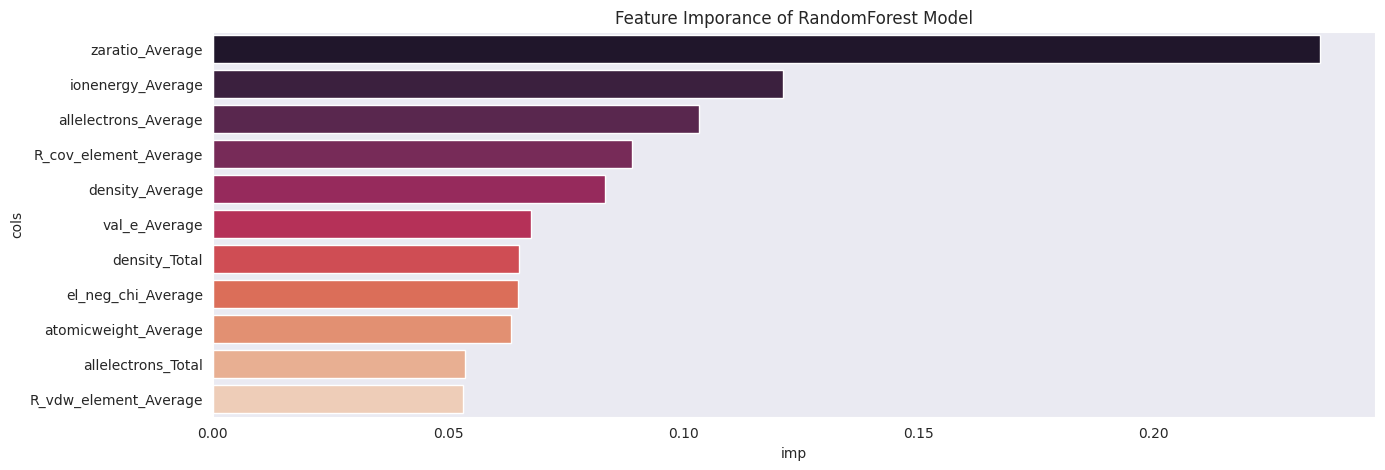

In [19]:
plotImportance("RandomForest Model",rfmodel)

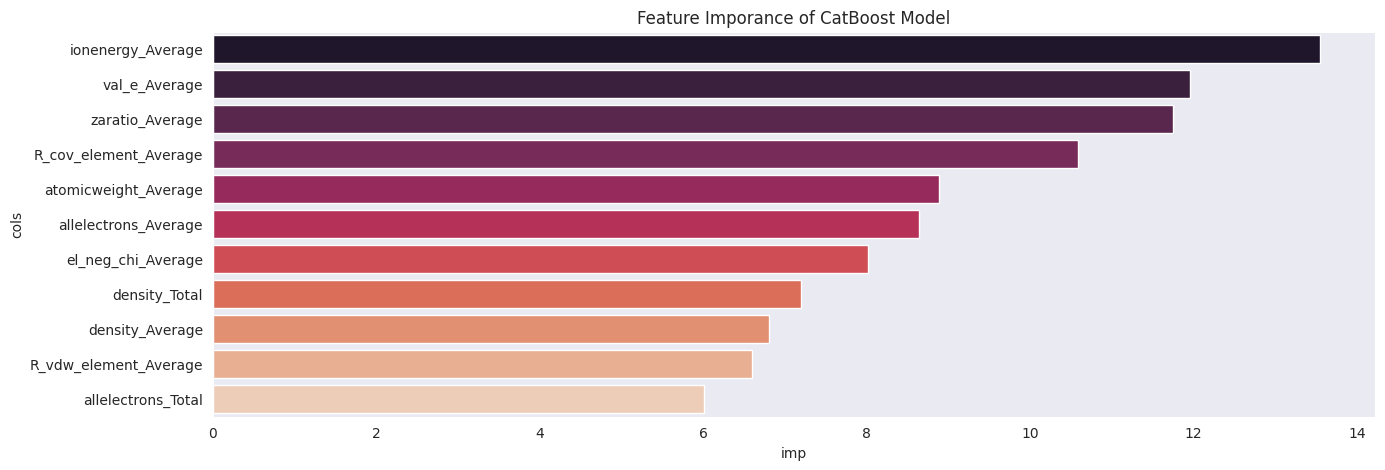

In [20]:
plotImportance("CatBoost Model",catmodel)

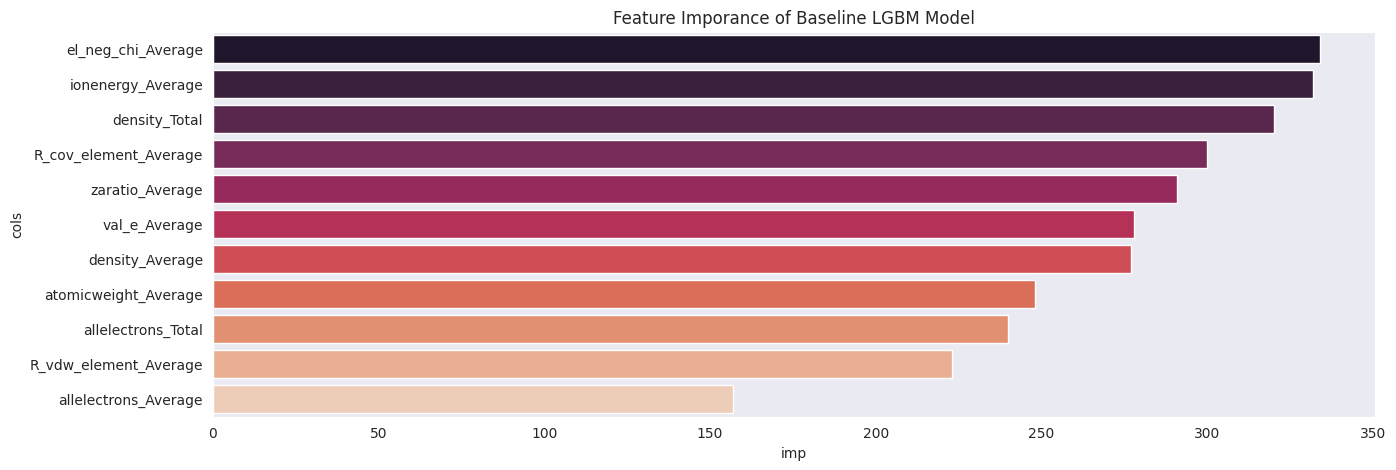

In [21]:
plotImportance("Baseline LGBM Model",lgbmmodel)

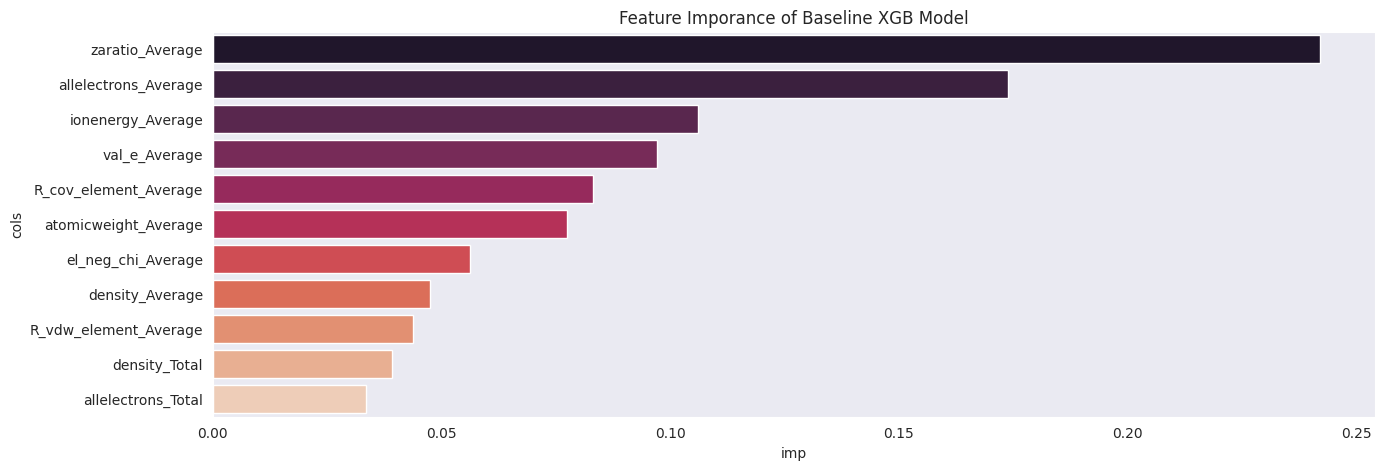

In [22]:
plotImportance("Baseline XGB Model",xgbmodel)

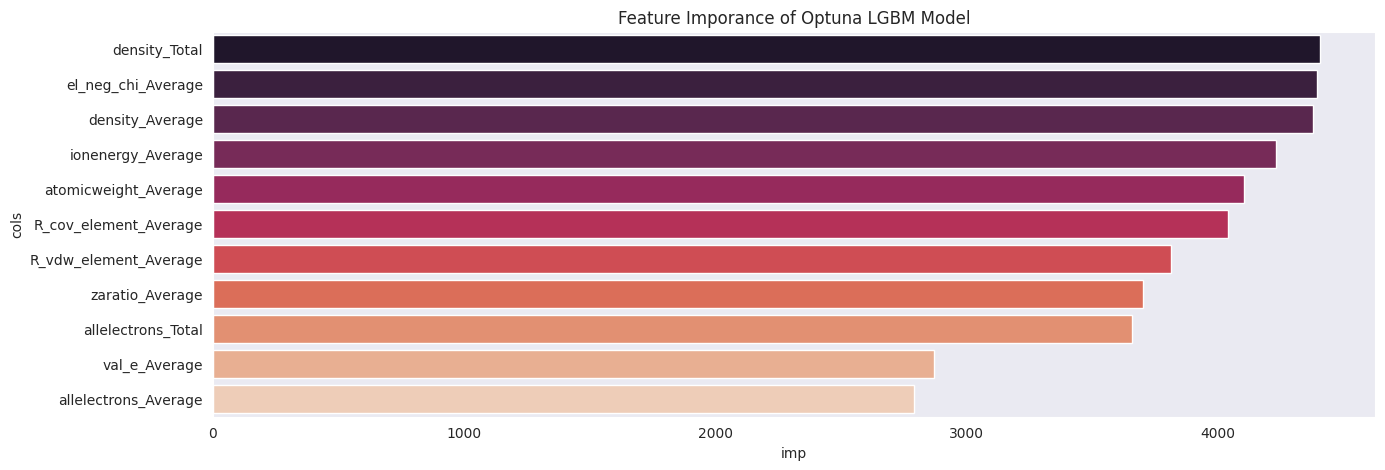

In [23]:
plotImportance("Optuna LGBM Model",lgbmopt)

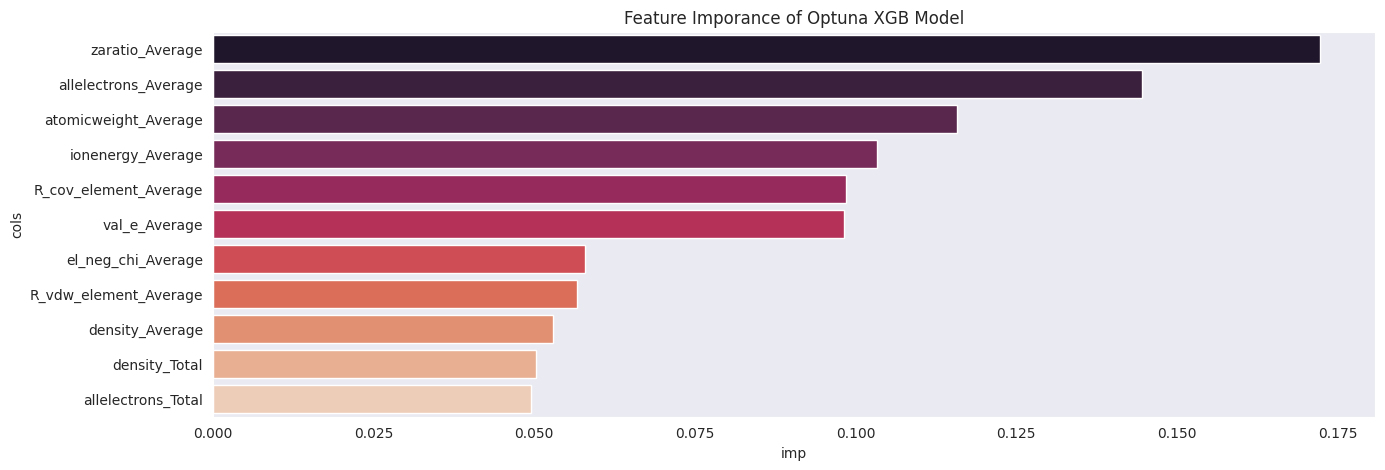

In [24]:
plotImportance("Optuna XGB Model",xgbopt)

<div id="7" style="background-color: #89B9AD88; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
    Creating 'submission.csv'
    </h1>
</div>

In [25]:
# rf_preds = rfmodel.predict(test_data)
# cat_preds = catmodel.predict(test_data)
# lgbm_preds = lgbmmodel.predict(test_data)
# preds = (rf_preds + cat_preds + lgbm_preds)/3

In [26]:
preds = vrmodel.predict(test_data)
sample["Hardness"] = preds

In [27]:
sample.to_csv("submission.csv",index=False,header=True)

<div id = "8" style="background-color: #89B9AD88; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
    Conclusion
    </h1>
    <h3 style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: center; color: #505050; line-height: 1.6;">
    If you found the notebook helpful, please Upvote the Notebook😊<br>
    If you have any suggestion, feel free to Comment & Tag me<br>
    </h3>
</div>

